In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def load_data(filepath):
    h5f = h5py.File(filepath, 'r')
    X_train = h5f['X_train'][:]
    y_train = h5f['y_train'][:]
    X_test = h5f['X_test'][:]
    y_test = h5f['y_test'][:]
    h5f.close()
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data('data/RockAI_224x224_testset50_images.h5')

num_classes = 2

#Pre-process the data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

datagen = ImageDataGenerator(
    get_random_eraser(v_l=0, v_h=1, pixel_level=True),
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 30,
    horizontal_flip=True,
    vertical_flip=True)
# datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
# datagen = ImageDataGenerator()
datagen.fit(X_train)

In [5]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze four convolution blocks
for layer in vgg_model.layers[:]:
    layer.trainable = False
    
# Make sure you have frozen the correct layers
# for i, layer in enumerate(vgg_model.layers):
#     print(i, layer.name, layer.trainable)

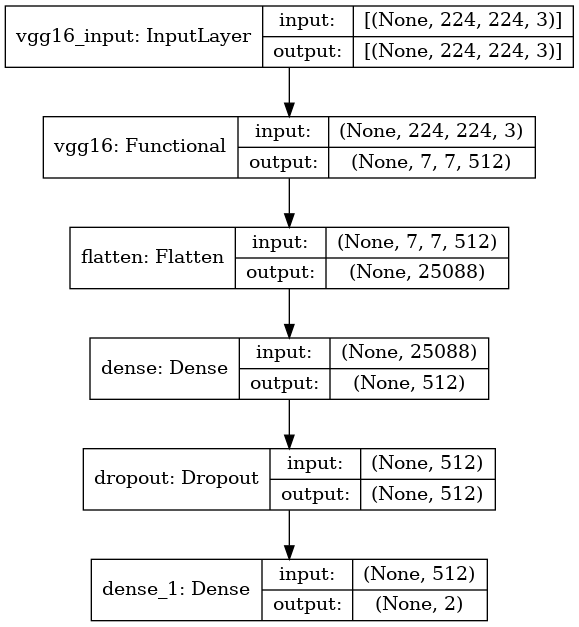

In [6]:
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_model)

# Add new layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
tf.keras.utils.plot_model(model, show_shapes=True, to_file='outdir/vgg_model.png')

In [7]:
batch_size = 32
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

historytemp = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=10)

Epoch 1/10
42/42 [==============================] - 13s 194ms/step - loss: 19.4097 - accuracy: 0.8837
Epoch 2/10
42/42 [==============================] - 7s 160ms/step - loss: 0.6335 - accuracy: 0.9371
Epoch 3/10
42/42 [==============================] - 7s 161ms/step - loss: 0.2081 - accuracy: 0.9558
Epoch 4/10
42/42 [==============================] - 7s 162ms/step - loss: 0.1645 - accuracy: 0.9625
Epoch 5/10
42/42 [==============================] - 7s 160ms/step - loss: 0.1110 - accuracy: 0.9656
Epoch 6/10
42/42 [==============================] - 7s 161ms/step - loss: 0.0893 - accuracy: 0.9699
Epoch 7/10
42/42 [==============================] - 7s 161ms/step - loss: 0.0845 - accuracy: 0.9673
Epoch 8/10
42/42 [==============================] - 7s 161ms/step - loss: 0.1245 - accuracy: 0.9645
Epoch 9/10
42/42 [==============================] - 7s 160ms/step - loss: 0.1086 - accuracy: 0.9678
Epoch 10/10
42/42 [==============================] - 7s 162ms/step - loss: 0.1018 - accuracy: 0.97

In [8]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 270ms/step - loss: 1.0469 - accuracy: 0.8100


[1.0468822717666626, 0.8100000023841858]